In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_758849/347984750.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [118]:
superflares = {'G': pd.read_csv('../data/G-type-superflares.csv'),
               'K': pd.read_csv('../data/K-type-superflares.csv'),
               'M': pd.read_csv('../data/M-type-superflares.csv')}

In [148]:
line_fits = {}
inv_line_fits = {}
scatter = {}
inv_scatter = {}
for stellar_class in ['G', 'K', 'M']:
    energies = superflares[stellar_class]['energy'].values
    amps = superflares[stellar_class]['flare_amp'].values
    sort = np.argsort(energies)
    energies = energies[sort]
    amps = amps[sort]

    params, cov = np.polyfit(np.log10(energies), np.log10(amps), 1, cov=True)
    line_fits[stellar_class] = np.poly1d(params)
    scatter[stellar_class] = np.std(np.log10(amps) / line_fits[stellar_class](np.log10(energies)))

    inv_line_fits[stellar_class] = np.poly1d([1/params[0], -params[1]/params[0]])
    inv_scatter[stellar_class] = np.std(np.log10(energies) / inv_line_fits[stellar_class](np.log10(amps)))

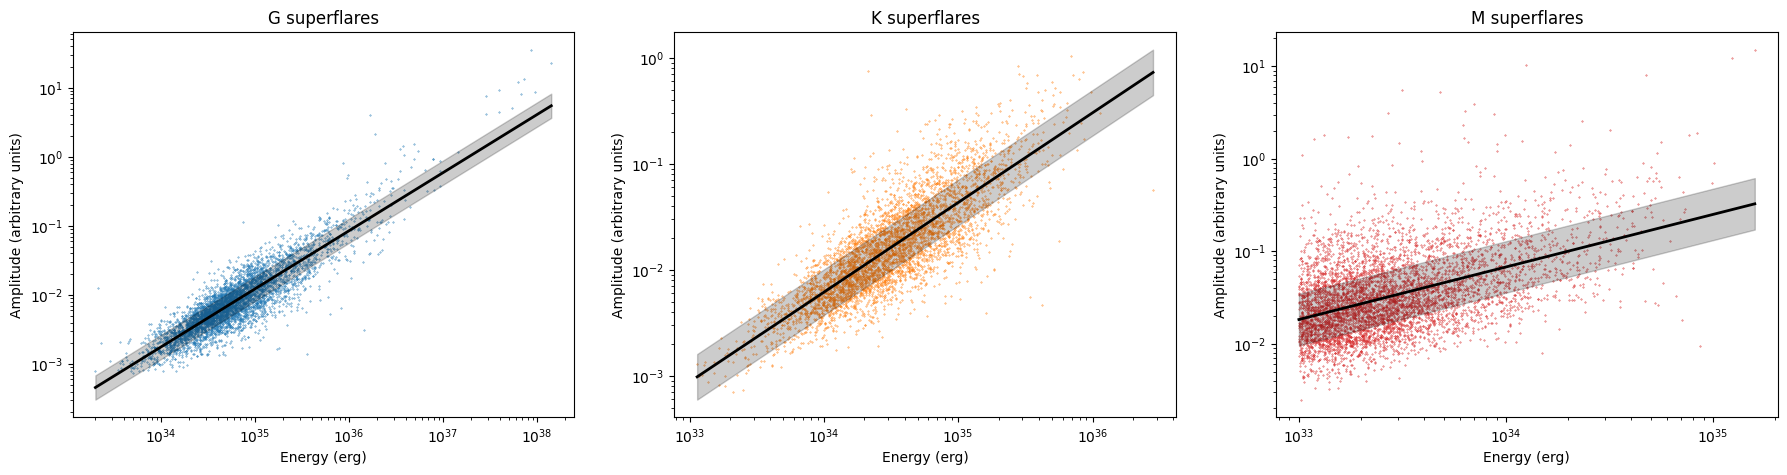

In [149]:
fig, axes = plt.subplots(1,3,figsize=(22, 5))

for ax, stellar_class, col in zip(axes, ['G', 'K', 'M'], ["C0", "C1", "C3"]):
    ax.scatter(superflares[stellar_class]['energy'], superflares[stellar_class]['flare_amp'], color=col, s=.1)
    ax.set(xscale='log', yscale='log', xlabel='Energy (erg)', ylabel='Amplitude (arbitrary units)',
           title=stellar_class + ' superflares')
    energy = np.sort(superflares[stellar_class]['energy'])
    log_amp = line_fits[stellar_class](np.log10(energy))
    ax.plot(energy, 10**log_amp, color='black', zorder=10, lw=2)
    ax.fill_between(energy, 10**(log_amp - scatter[stellar_class]), 10**(log_amp + scatter[stellar_class]),
            color='black', alpha=0.2)
plt.show()

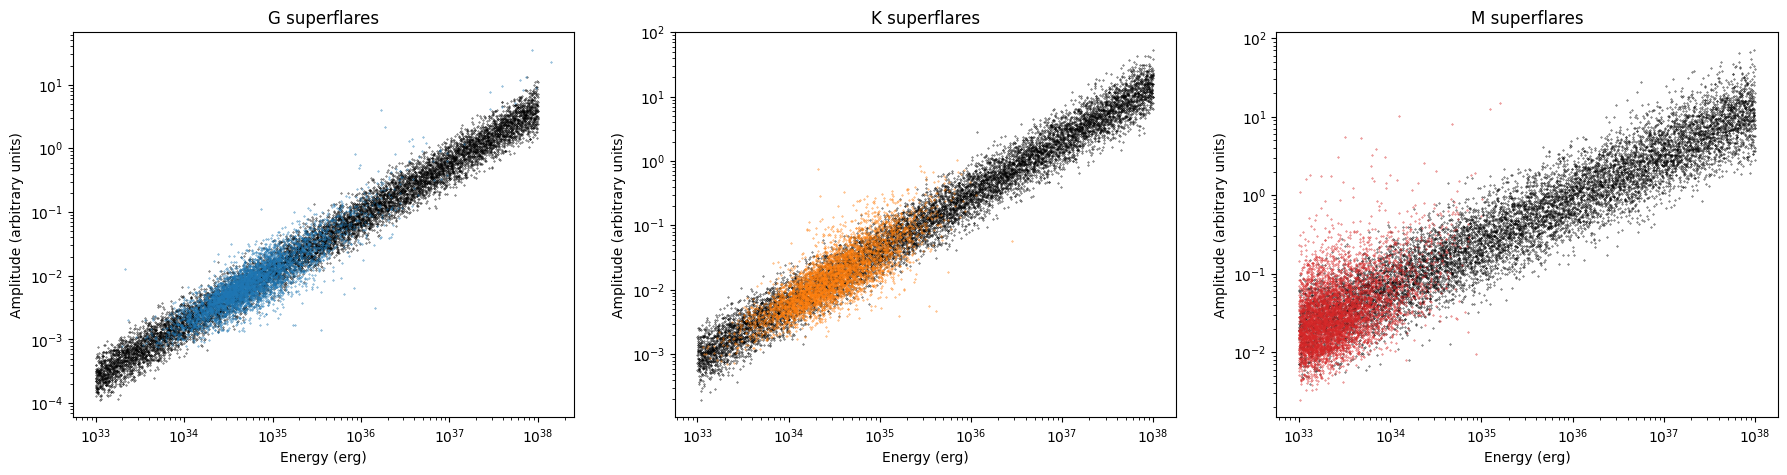

In [150]:
fig, axes = plt.subplots(1,3,figsize=(22, 5))

for ax, stellar_class, col in zip(axes, ['G', 'K', 'M'], ["C0", "C1", "C3"]):

    energies = np.logspace(33, 38, 10000)
    log_amps = line_fits[stellar_class](np.log10(energies))
    scatters = np.random.normal(0, scatter[stellar_class], len(energies))
    amps = 10**(log_amps + scatters)

    ax.scatter(superflares[stellar_class]['energy'], superflares[stellar_class]['flare_amp'], color=col, s=.1)
    ax.set(xscale='log', yscale='log', xlabel='Energy (erg)', ylabel='Amplitude (arbitrary units)',
           title=stellar_class + ' superflares')
    
    ax.scatter(energies, amps, color='black', s=.1, zorder=-1)

plt.show()

# Other direction

In [160]:
def amplitude_to_energy(amp, stellar_class):
    return 10**(inv_line_fits[stellar_class](np.log10(amp))
                + np.random.normal(0, scatter[stellar_class],
                                   len(amp) if isinstance(amp, np.ndarray) else 1))

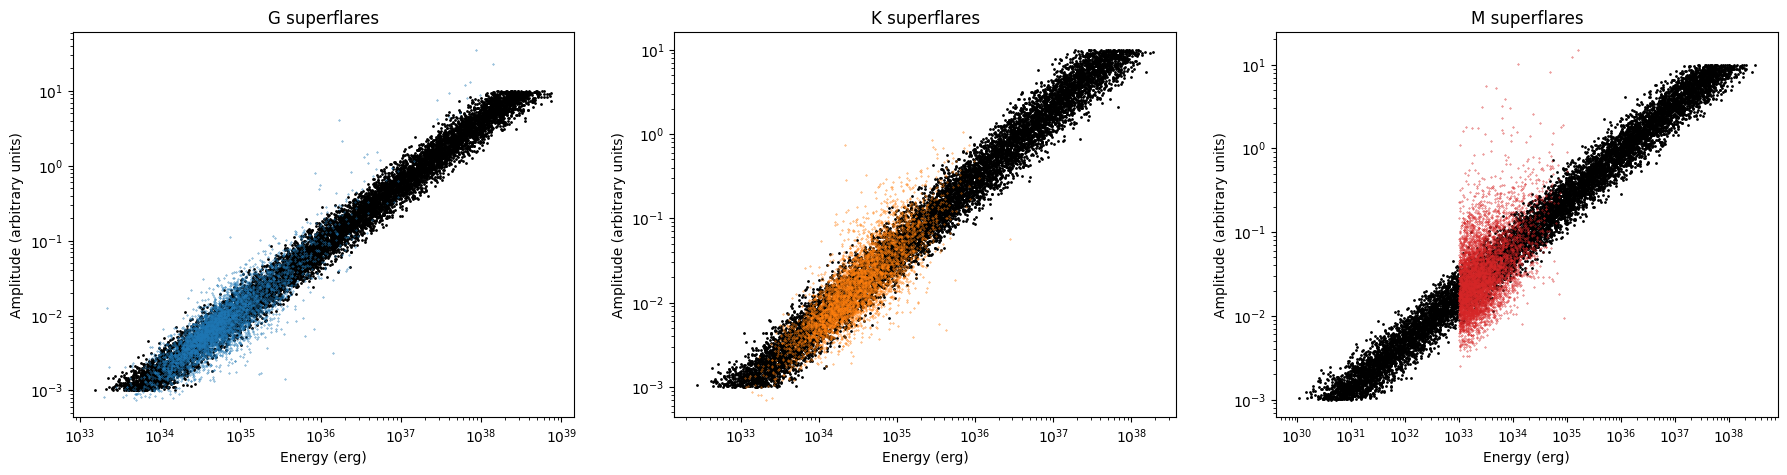

In [161]:
fig, axes = plt.subplots(1,3,figsize=(22, 5))

for ax, stellar_class, col in zip(axes, ['G', 'K', 'M'], ["C0", "C1", "C3"]):
    ax.scatter(superflares[stellar_class]['energy'], superflares[stellar_class]['flare_amp'], color=col, s=.1)
    ax.set(xscale='log', yscale='log', xlabel='Energy (erg)', ylabel='Amplitude (arbitrary units)',
           title=stellar_class + ' superflares')
    
    amps = np.logspace(-3, 1, 10000)
    log_E = inv_line_fits[stellar_class](np.log10(amps))
    scatters = np.random.normal(0, scatter[stellar_class], len(amps))
    E = 10**(log_E + scatters)
    ax.scatter(amplitude_to_energy(amps, stellar_class), amps, color='black', s=1, zorder=-1)

plt.show()